# Project 1: Natural Language Processing

Learning Objectives:
- Increase familiarity with pytorch
- Learn how to use an LSTM model
- Learn how to integrate Deep learning models
- Learn how to process/handle a new type of data
- Practice neural network optimization

Using pytorch, You will develop a POS tagger that uses both a bi-directional LSTM and a CNN for maximum accuracy. You can use the pytorch LSTM example and the CNN tutorial as a reference point. <br>
<br>
Required Structural Components: a word embedding, a CNN, a bi-directional LSTM, and linear layers.

## Import packages

In [1]:
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# standard DS packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# natural language toolkit
import nltk

## Exploratory data analysis

Read in corpus and split word/tag with nltk

In [2]:
f = open("train.txt", "r") # open text file
words = f.read()
tagged = [nltk.tag.str2tuple(t) for t in words.split()]

Visualize counts of each POS

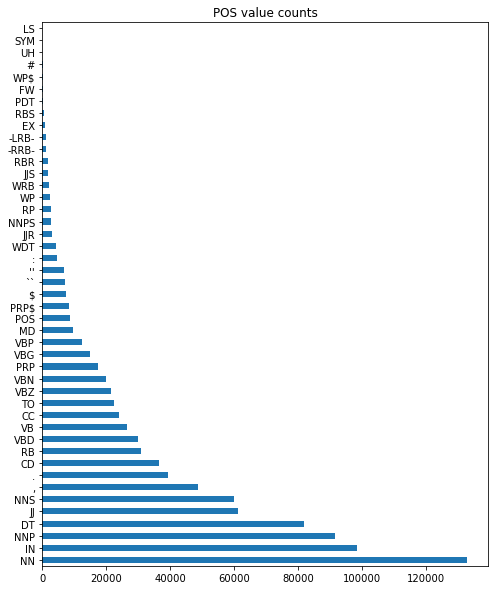

In [3]:
df = pd.DataFrame(tagged, columns =['Word', 'Tag'])
df['Tag'].value_counts().plot(kind='barh', figsize=(8, 10), title='POS value counts');

## Prepare data

In [4]:
f = open("train.txt", "r") # open text file
lines = f.readlines()
text = [sentence.split() for sentence in lines]

tagged = []
for sentence in text:
    words = []
    for word in sentence:
        tags = nltk.tag.str2tuple(word)
        words.append(tags)
    tagged.append(words)

In [6]:
tagged[0]

[('In', 'IN'),
 ('an', 'DT'),
 ('Oct.', 'NNP'),
 ('19', 'CD'),
 ('review', 'NN'),
 ('of', 'IN'),
 ('``', '``'),
 ('The', 'DT'),
 ('Misanthrope', 'NN'),
 ("''", "''"),
 ('at', 'IN'),
 ('Chicago', 'NNP'),
 ("'s", 'POS'),
 ('Goodman', 'NNP'),
 ('Theatre', 'NNP'),
 ('(', '-LRB-'),
 ('``', '``'),
 ('Revitalized', 'VBN'),
 ('Classics', 'NNS'),
 ('Take', 'VBP'),
 ('the', 'DT'),
 ('Stage', 'NN'),
 ('in', 'IN'),
 ('Windy', 'NNP'),
 ('City', 'NNP'),
 (',', ','),
 ("''", "''"),
 ('Leisure', 'NN'),
 ('&', 'CC'),
 ('Arts', 'NNS'),
 (')', '-RRB-'),
 (',', ','),
 ('the', 'DT'),
 ('role', 'NN'),
 ('of', 'IN'),
 ('Celimene', 'NNP'),
 (',', ','),
 ('played', 'VBN'),
 ('by', 'IN'),
 ('Kim', 'NNP'),
 ('Cattrall', 'NNP'),
 (',', ','),
 ('was', 'VBD'),
 ('mistakenly', 'RB'),
 ('attributed', 'VBN'),
 ('to', 'TO'),
 ('Christina', 'NNP'),
 ('Haag', 'NNP'),
 ('.', '.')]

In [7]:
training_data = []
for sentence in tagged:
    words = []
    tags = []
    for word, tag in sentence:
        words.append(word)
        tags.append(tag)
    s = (words, tags)
    training_data.append(s)

In [8]:
training_data[0]

(['In',
  'an',
  'Oct.',
  '19',
  'review',
  'of',
  '``',
  'The',
  'Misanthrope',
  "''",
  'at',
  'Chicago',
  "'s",
  'Goodman',
  'Theatre',
  '(',
  '``',
  'Revitalized',
  'Classics',
  'Take',
  'the',
  'Stage',
  'in',
  'Windy',
  'City',
  ',',
  "''",
  'Leisure',
  '&',
  'Arts',
  ')',
  ',',
  'the',
  'role',
  'of',
  'Celimene',
  ',',
  'played',
  'by',
  'Kim',
  'Cattrall',
  ',',
  'was',
  'mistakenly',
  'attributed',
  'to',
  'Christina',
  'Haag',
  '.'],
 ['IN',
  'DT',
  'NNP',
  'CD',
  'NN',
  'IN',
  '``',
  'DT',
  'NN',
  "''",
  'IN',
  'NNP',
  'POS',
  'NNP',
  'NNP',
  '-LRB-',
  '``',
  'VBN',
  'NNS',
  'VBP',
  'DT',
  'NN',
  'IN',
  'NNP',
  'NNP',
  ',',
  "''",
  'NN',
  'CC',
  'NNS',
  '-RRB-',
  ',',
  'DT',
  'NN',
  'IN',
  'NNP',
  ',',
  'VBN',
  'IN',
  'NNP',
  'NNP',
  ',',
  'VBD',
  'RB',
  'VBN',
  'TO',
  'NNP',
  'NNP',
  '.'])

In [10]:
word_to_ix = {}
tag_to_ix = {}
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)
            
print(word_to_ix)
print(tag_to_ix)

{'In': 0, 'an': 1, 'Oct.': 2, '19': 3, 'review': 4, 'of': 5, '``': 6, 'The': 7, 'Misanthrope': 8, "''": 9, 'at': 10, 'Chicago': 11, "'s": 12, 'Goodman': 13, 'Theatre': 14, '(': 15, 'Revitalized': 16, 'Classics': 17, 'Take': 18, 'the': 19, 'Stage': 20, 'in': 21, 'Windy': 22, 'City': 23, ',': 24, 'Leisure': 25, '&': 26, 'Arts': 27, ')': 28, 'role': 29, 'Celimene': 30, 'played': 31, 'by': 32, 'Kim': 33, 'Cattrall': 34, 'was': 35, 'mistakenly': 36, 'attributed': 37, 'to': 38, 'Christina': 39, 'Haag': 40, '.': 41, 'Ms.': 42, 'plays': 43, 'Elianti': 44, 'Rolls-Royce': 45, 'Motor': 46, 'Cars': 47, 'Inc.': 48, 'said': 49, 'it': 50, 'expects': 51, 'its': 52, 'U.S.': 53, 'sales': 54, 'remain': 55, 'steady': 56, 'about': 57, '1,200': 58, 'cars': 59, '1990': 60, 'luxury': 61, 'auto': 62, 'maker': 63, 'last': 64, 'year': 65, 'sold': 66, '1,214': 67, 'Howard': 68, 'Mosher': 69, 'president': 70, 'and': 71, 'chief': 72, 'executive': 73, 'officer': 74, 'he': 75, 'anticipates': 76, 'growth': 77, 'for': 

In [14]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 32
HIDDEN_DIM = 32

In [15]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        
        self.hidden_dim = hidden_dim

        ### The embedding class of pytorch stores features corresponding to each word that can be used/optimized 
        ### by the LSTM
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states corresponding to each word
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # MLP that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        
        ### sentence goes into the embedding model to get the feature values of each word
        embeds = self.word_embeddings(sentence)
        
        ### get the LSTM feature values for each sentence
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        
        ### Use MLP to make predictions
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [16]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)


for epoch in range(3000):  # again, normally you would NOT do 3 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)

        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        
    

# See what the scores are after training
with torch.no_grad():
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)

    print(tag_scores)

KeyboardInterrupt: 